In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from data import ImageDataModule
from utils.visualization import imshow_unnorm

dataset = ImageDataModule(dataset="mnist", batch_size=4, n_workers=1)
dataset.setup("fit")
train_loader = dataset.train_dataloader()
batch = next(iter(train_loader))

/opt/homebrew/Caskroom/mambaforge/base/envs/IP/lib/python3.9/site-packages/torch/distributed/_shard/partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
/opt/homebrew/Caskroom/mambaforge/base/envs/IP/lib/python3.9/site-packages/torch/distributed/_shard/replicated_tensor.py:20: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)


torch.Size([1, 28, 28]) tensor(-1.) tensor(1.) 6 - six


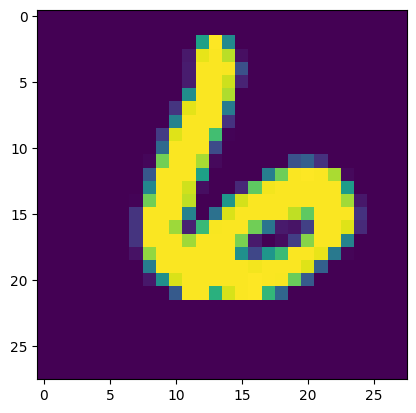

In [3]:
images, labels = batch

image = images[0]
label = labels[0]
print(image.shape, image.min(), image.max(), dataset.dataset_full.classes[label])
imshow_unnorm(image)

In [4]:
def _add_pos_encodings_to_img_batch(x: torch.Tensor):
    b, c, h, w = x.size()
    # add position encoding as in wattersSpatialBroadcastDecoder2019
    width_pos = torch.linspace(-1, 1, w)
    height_pos = torch.linspace(-1, 1, w)
    xb, yb = torch.meshgrid(width_pos, height_pos)
    # match dimensions of x except for channels
    xb = xb.expand(b, 1, -1, -1).to(x.device)
    yb = yb.expand(b, 1, -1, -1).to(x.device)
    x_full = torch.concat((x, xb, yb), dim=1)
    assert x_full.size() == torch.Size([b, c + 2, h, w])
    return x_full

/opt/homebrew/Caskroom/mambaforge/base/envs/IP/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1677226299084/work/aten/src/ATen/native/TensorShape.cpp:3489.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


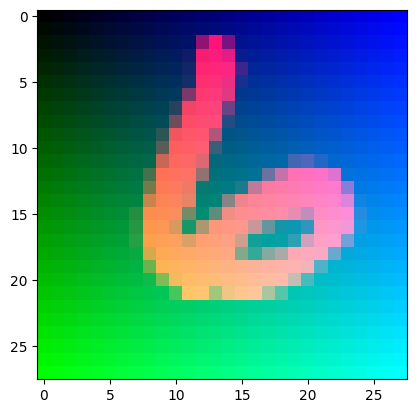

In [5]:
images_with_pos = _add_pos_encodings_to_img_batch(images)
imshow_unnorm(images_with_pos[0])

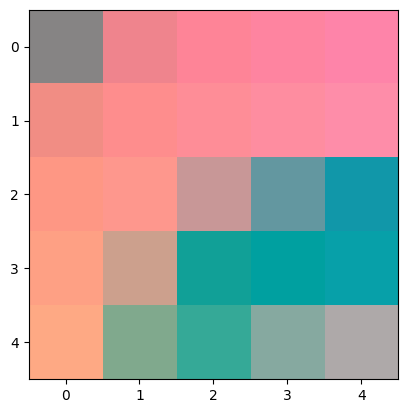

In [6]:
patch_dim = 5
cur_center_idx = [14, 14]

cur_patch = images_with_pos[:, :, cur_center_idx[0]:cur_center_idx[0]+patch_dim, cur_center_idx[1]:cur_center_idx[1]+patch_dim]
imshow_unnorm(cur_patch[0])

In [7]:
b, c, h, w = images.size()
width_pos = torch.linspace(-1, 1, w)
height_pos = torch.linspace(-1, 1, h)
xb, yb = torch.meshgrid(width_pos, height_pos)
# match dimensions of x except for channels
xb = xb.expand(1, -1, -1)
yb = yb.expand(1, -1, -1)
pos_values = torch.concat((xb, yb), dim=0)
pos_values[:, 14, 14]

tensor([0.0370, 0.0370])

In [8]:
def pixel_coords_to_pos(coords):
    mid = (torch.tensor([h, w]) - 1)/2
    return (coords - mid) / mid

def pos_to_pixel_coords(pos):
    mid = (torch.tensor([h, w]) - 1)/2
    return (pos * mid) + mid


print(pos_to_pixel_coords(pixel_coords_to_pos(torch.tensor([[0,0], [14, 14], [14, 15], [15, 14], [15, 15], [27, 27]]))))

tensor([[ 0.,  0.],
        [14., 14.],
        [14., 15.],
        [15., 14.],
        [15., 15.],
        [27., 27.]])


In [9]:
pos_to_pixel_coords(pos_values.view(2, -1).T).T.view(2, h, w)[:, 0, 0]

tensor([0., 0.])

torch.Size([4, 3, 14, 14])


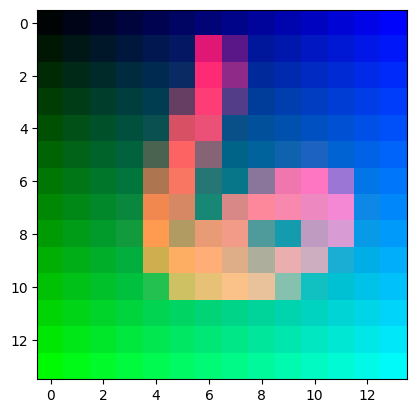

In [10]:
from torch.nn import AvgPool2d

pool_factor = 2
pool = AvgPool2d(pool_factor)

pooled = pool(images_with_pos)
print(pooled.shape)
imshow_unnorm(pooled[0])

In [11]:
# cur_patch_topleft_pos = cur_patch[:, 1:, 0, 0]
# cur_patch_bottomright_pos = cur_patch[:, 1:, -1, -1]

# cur_patch_topleft_coords = pos_to_pixel_coords(cur_patch_topleft_pos)
# cur_patch_bottomright_coords = pos_to_pixel_coords(cur_patch_bottomright_pos) + 1 # +1 to get to the bottom right corner

# ring_start = (cur_patch_topleft_coords - 2).int()
# ring_end = (cur_patch_bottomright_coords + 2).int()
# print(cur_patch_topleft_coords, ring_start, ring_end)
# # 2d index into images_with_pos to get the ring
# # shape (b, c, patch_dim + 4, patch_dim + 4)
# # use torch.gather
# ring = images_with_pos.gather()


# # ring = images_with_pos[:, :, [5:10], 5:10]
# # print(ring.shape)

# # images_with_pos[:, :, ring_start[0]:ring_end[0], ring_start[1]:ring_end[1]].shape

# # cur_patch_idx = pos_to_pixel_coords(cur_patch_pos.transpose(1, 3).reshape(-1, 2)).reshape(b, patch_dim, patch_dim, 2).transpose(1, 3)
# # cur_patch_idx.shape

In [12]:
def get_ring_around_pos(image, pos, ring_start, ring_end, pool_factor):
    # pos is in [-1, 1] coordinates
    # ring_start and ring_end are in the square offset from pos to start and end the ring
    # pool_factor is the factor by which to downsample the image
    # returns a tensor of shape (c, ring_start * 2 + )
    # returns a tensor of shape (c, ring_end - ring_start)
    # where c is the number of channels in the image
    # and ring_end - ring_start is the number of pixels in the ring
    pass

In [13]:
from typing import *


torch.random.manual_seed(0)

a = torch.rand(2, 5,7 , 7)
# print(a)
want = torch.stack((a[0, :, 0:3, 1:4], a[1, :, 2:5, 3:6]))
# print(want)
print(f"want: {want.shape}")

# a[:, [slice(0, 3), slice(2, 5)], [slice(1, 4), slice(3, 6)]]
batch_idx = torch.arange(2).view(2, 1, 1, 1).expand(2, 5, 3, 3)
print("batch_idx.shape", batch_idx.shape)
channel_idx = torch.arange(5).view(1, 5, 1, 1).expand(2, 5, 3, 3)
print("channel_idx.shape", channel_idx.shape)
row_idx = torch.stack([torch.arange(0,3), torch.arange(2,5)]).view(2, 1, 3, 1).expand(2, 5, 3, 3)
print("row_idx.shape", row_idx.shape)
col_idx = torch.stack([torch.arange(1,4), torch.arange(3,6)]).view(2, 1, 1, 3).expand(2, 5, 3, 3)
print("col_idx.shape", col_idx.shape)
# row_idx = torch.tensor([[0,1,2], [2,3,4]]).unsqueeze(2).repeat(1, 1, 3)
# print(row_idx.shape)
# col_idx = torch.tensor([[1,2,3], [3,4,5]]).unsqueeze(1).repeat(1, 3, 1)
# print(col_idx.shape)

get = a[batch_idx, channel_idx, row_idx, col_idx]
print(get)
print(get.shape)
print((get == want).all())

# def dynamic_slice_index(a: torch.Tensor, indices: List[torch.Tensor]):
#     """
#     a: tensor of shape (dim1, dim2, dim3, ...)
#     indices: list of tensors of shape (dim1_indices, dim2_indices, dim3_indices, ...)
#     """
#     assert len(indices) == a.dim()



# get = a[[[0]*9, [1]*9], [[0,1,2]*3, [2,3,4]*3], [[[1,1,1,2,2,2,3,3,3], [3,3,3,4,4,4,5,5,5]]]]
# get, get.shape



# gather_idx = torch.tensor([[[0, 1, 2], [1, 2, 3]], [[2, 3, 4], [3, 4, 5]]])#.unsqueeze(1).repeat(1, 3, 1, 1)
# print(f"gather: {gather_idx.shape}")

# g = torch.gather(a, 1, gather_idx)

# print(g)
# print(g.shape)
# print((g == want).any())


want: torch.Size([2, 5, 3, 3])
batch_idx.shape torch.Size([2, 5, 3, 3])
channel_idx.shape torch.Size([2, 5, 3, 3])
row_idx.shape torch.Size([2, 5, 3, 3])
col_idx.shape torch.Size([2, 5, 3, 3])
tensor([[[[0.7682, 0.0885, 0.1320],
          [0.4556, 0.6323, 0.3489],
          [0.5185, 0.6977, 0.8000]],

         [[0.8198, 0.9971, 0.6984],
          [0.1123, 0.1535, 0.2417],
          [0.7745, 0.4369, 0.5191]],

         [[0.2121, 0.9704, 0.8369],
          [0.1235, 0.1143, 0.4725],
          [0.9537, 0.8426, 0.0784]],

         [[0.2515, 0.1168, 0.0321],
          [0.0178, 0.8119, 0.1087],
          [0.0513, 0.0683, 0.4218]],

         [[0.6709, 0.2020, 0.4891],
          [0.2097, 0.8500, 0.3203],
          [0.4012, 0.5627, 0.3858]]],


        [[[0.7648, 0.8838, 0.6814],
          [0.6359, 0.2634, 0.2650],
          [0.9384, 0.1753, 0.4431]],

         [[0.4229, 0.6737, 0.3176],
          [0.7067, 0.5392, 0.5418],
          [0.9506, 0.7939, 0.5670]],

         [[0.1617, 0.0067, 0.0985],

## Gaussian Filter Pooling

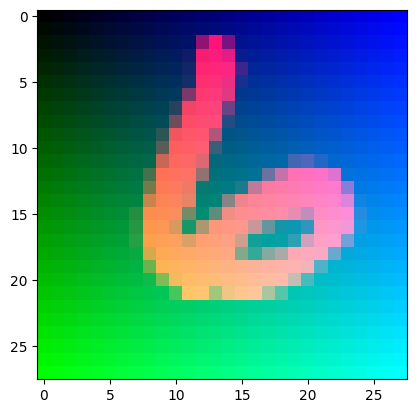

In [14]:
imshow_unnorm(images_with_pos[0])

In [15]:
def make_gaussian_map(x_extent, y_extent, center_x, center_y, amplitude, sigma):
    """Make a gaussian map centered at (center_x, center_y) in space."""
    # # assert that stimulus center is within the stimulus extent
    assert center_x <= x_extent and center_y <= y_extent

    x, y = np.meshgrid(np.arange(x_extent), np.arange(y_extent), indexing="ij")
    s = amplitude * np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * sigma**2))
    return s

torch.Size([7, 7, 28, 28])


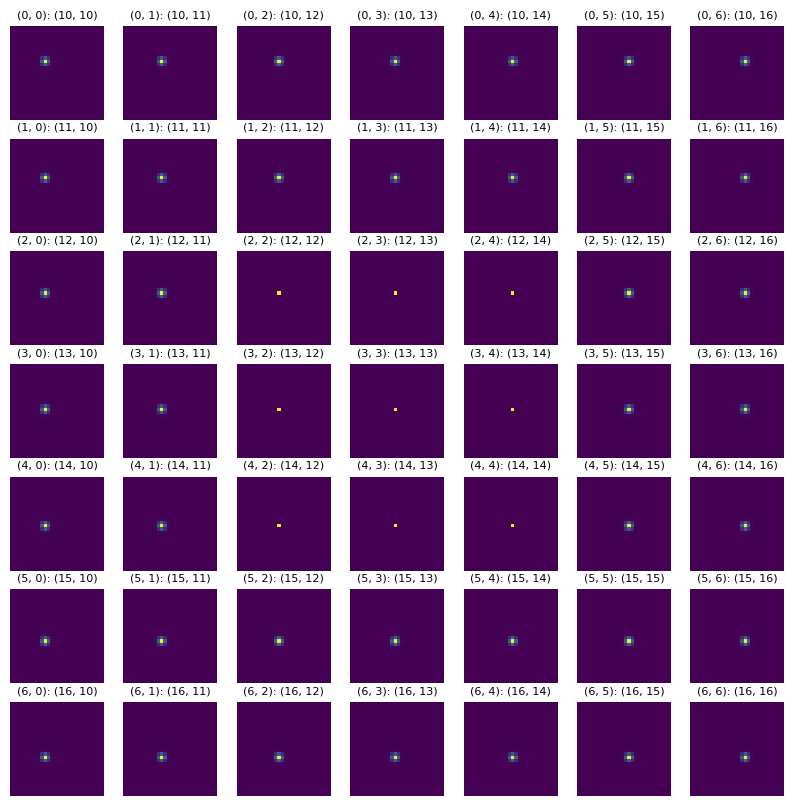

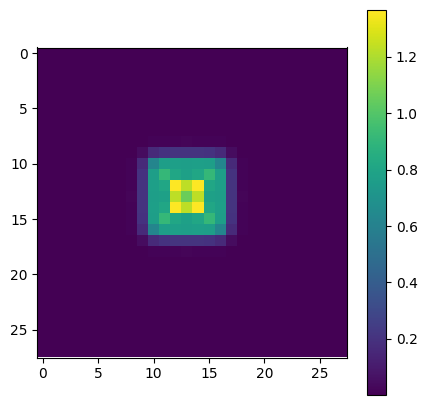

In [16]:
x_extent, y_extent = images_with_pos.shape[2:]

patch_dim = 7
inner_patch_dim = 3
max_receptive_field_x, max_receptive_field_y = x_extent, y_extent
# position patch in center of receptive field
patch_top_left_x, patch_top_left_y = (max_receptive_field_x - patch_dim) // 2, (
    max_receptive_field_y - patch_dim
) // 2
# position inner patch in center of patch
inner_patch_top_left_x, inner_patch_top_left_y = (
    patch_top_left_x + (patch_dim - inner_patch_dim) // 2,
    patch_top_left_y + (patch_dim - inner_patch_dim) // 2,
)

filters = torch.zeros(
    (patch_dim, patch_dim, max_receptive_field_x, max_receptive_field_y)
)  # *2 bc filter needs to reach outside image if needed
for i in range(patch_dim):
    for j in range(patch_dim):
        center_x, center_y = (
            patch_top_left_x + i,
            patch_top_left_y + j,
        )
        # if center is inside inner patch on both x and y, make point filter
        # otherwise, make gaussian filter
        if (
            center_x >= inner_patch_top_left_x
            and center_x < inner_patch_top_left_x + inner_patch_dim
            and center_y >= inner_patch_top_left_y
            and center_y < inner_patch_top_left_y + inner_patch_dim
        ):
            filters[i, j, center_x, center_y] = 1

        else:
            f = torch.tensor(
                make_gaussian_map(
                    max_receptive_field_x,
                    max_receptive_field_y,
                    center_x,
                    center_y,
                    10,
                    2,
                )
            )
            # softmax to make sure filter sums to 1
            filters[i, j, :, :] = torch.nn.functional.softmax(f.view(-1), dim=0).view(
                max_receptive_field_x, max_receptive_field_y
            )


# plot all filters in a grid
fig, axs = plt.subplots(patch_dim, patch_dim, figsize=(10, 10))
for i in range(patch_dim):
    for j in range(patch_dim):
        axs[i, j].imshow(filters[i, j, :, :])
        axs[i, j].axis("off")
        # title
        axs[i, j].set_title(
            f"({i}, {j}): ({patch_top_left_x + i}, {patch_top_left_y + j})", fontsize=8
        )

# composit all filters
print(filters.shape)
composite_filter = torch.sum(filters, dim=(0, 1))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
composite = ax.imshow(composite_filter)
fig.colorbar(composite)


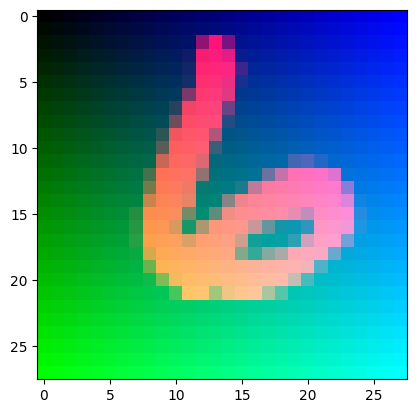

In [17]:
image = images_with_pos[0]
image.shape
imshow_unnorm(image)

torch.Size([49, 3])
torch.Size([3, 7, 7])


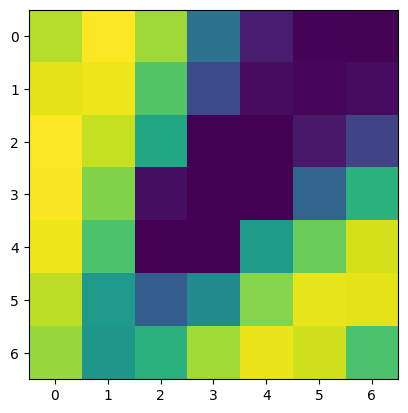

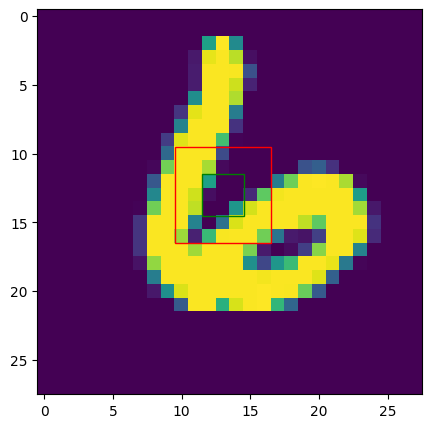

In [18]:
# filter image

from matplotlib import patches


filters_flat = filters.view(patch_dim * patch_dim, -1)

filtered_image = filters_flat @ image.view(image.shape[0], -1).T
print(filtered_image.shape)

filtered_image = filtered_image.T.view(image.shape[0], patch_dim, patch_dim)

print(filtered_image.shape)

# fig, axs = plt.subplots(patch_dim, patch_dim, figsize=(10, 10))
# for i in range(patch_dim):
#     for j in range(patch_dim):
#         axs[i, j].imshow(filtered_image[0, i, j])
#         axs[i, j].axis("off")
#         # title
#         axs[i, j].set_title(
#             f"({i}, {j}): ({patch_top_left_x + i}, {patch_top_left_y + j})", fontsize=8
#         )

imshow_unnorm(filtered_image[[0]])

# plot where the patch is in the image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(image[0])
ax.add_patch(
    patches.Rectangle(
        (patch_top_left_x-0.5, patch_top_left_y-0.5),
        patch_dim,
        patch_dim,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
)
# plot where the inside patch is in the image
ax.add_patch(
    patches.Rectangle(
        (inner_patch_top_left_x-0.5, inner_patch_top_left_y-0.5),
        inner_patch_dim,
        inner_patch_dim,
        linewidth=1,
        edgecolor="g",
        facecolor="none",
    )
)


## Foveal Cartesian Geometry

foveated_im_dim=8 peri_ring_radii=array([ 5, 13]) peri_sampling_ratios=array([0.55555556, 0.28      ]), n_in_ring=array([ 36, 100]), n_should_be_in_ring=[20, 28]
ring 0: r=5
ring 1: r=13


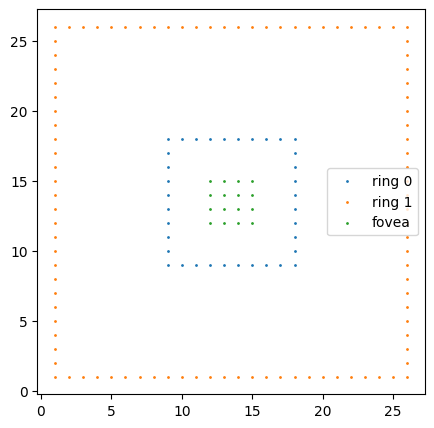

In [19]:
center_x, center_y = 14, 14

max_ring_radius = 14
fovea_radius = 2
num_peri_rings_to_attempt = 2

foveated_im_dim = 2 * (fovea_radius + num_peri_rings_to_attempt)

a = np.exp((np.log(max_ring_radius / fovea_radius)) / num_peri_rings_to_attempt)
peri_ring_radii = np.floor([fovea_radius * a**i for i in range(1, num_peri_rings_to_attempt + 1)])
eligible_radius_mask = np.array([fovea_radius < r <= max_ring_radius for r in peri_ring_radii]).astype(bool)
peri_ring_radii = peri_ring_radii[eligible_radius_mask].astype(int)
num_peri_rings = len(peri_ring_radii)

def get_num_ring_pixels_from_r(r):
    """Get number of pixels in a square ring of given radius centered at a given point"""
    return ((r * 2) - 1) * 4

n_in_ring = get_num_ring_pixels_from_r(peri_ring_radii)
n_should_be_in_ring = [get_num_ring_pixels_from_r(fovea_radius + i + 1) for i in range(len(peri_ring_radii))]

# sampling ratios for each ring
peri_sampling_ratios = n_should_be_in_ring / n_in_ring # [(fovea_radius + i+1) / r for i, r in enumerate(peri_ring_radii)]

print(f"{foveated_im_dim=}", f"{peri_ring_radii=}", f"{peri_sampling_ratios=}, {n_in_ring=}, {n_should_be_in_ring=}")

def get_indices_in_ring(x_extent, y_extent, x_center, y_center, radius):
    """Get indices of pixels in a square ring of given radius centered at (x_center, y_center)"""
    x, y = np.meshgrid(np.arange(x_extent), np.arange(y_extent), indexing="ij")
    xy = np.stack([x, y], axis=-1)

    # get indices of pixels in ring
    ring_mask = np.zeros((x_extent, y_extent), dtype=bool)
    ring_mask[x_center - radius: x_center + radius, y_center - radius: y_center + radius] = True
    ring_mask[x_center - radius + 1: x_center + radius - 1, y_center - radius + 1 : y_center + radius - 1] = False

    # plt.imshow(ring_mask)

    # get xy according to ring_mask
    ring_xy = xy[ring_mask]

    return ring_xy#, ring_mask

# ri = get_indices_in_ring(28, 28, 14, 14, 2)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i, r in enumerate(peri_ring_radii):
    print(f"ring {i}: {r=}")
    ri = get_indices_in_ring(28, 28, center_x, center_y, r)
    ax.scatter(ri[:, 0], ri[:, 1], s=1, label=f"ring {i}")

fovea_indices = np.concatenate([get_indices_in_ring(28, 28, center_x, center_y, r) for r in range(1, fovea_radius + 1)])
ax.scatter(fovea_indices[:, 0], fovea_indices[:, 1], s=1, label=f"fovea")

ax.legend()
plt.show()


ring 0: r=5
sample_n=20
ring 1: r=13
sample_n=28


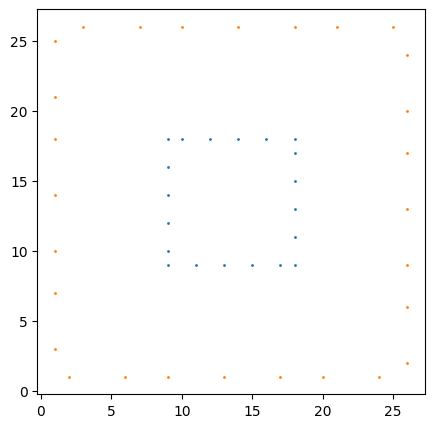

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# sample evenly from each ring according to sampling ratio

sampled_indices = []
for i, r in enumerate(peri_ring_radii):
    print(f"ring {i}: {r=}")
    ri = get_indices_in_ring(28, 28, center_x, center_y, r)
    # traverse ring indices clockwise starting from top left using arctan2
    ri = ri[np.argsort(np.arctan2(ri[:, 0] - center_x, ri[:, 1] - center_y))]

    # sample according to sampling ratio
    sample_n = np.floor(len(ri) * peri_sampling_ratios[i]).astype(int)

    print(f"{sample_n=}")
    sample = np.round(np.linspace(0, len(ri), sample_n, endpoint=False)).astype(int)
    ri = ri[sample]

    sampled_indices.append(ri)

    ax.scatter(ri[:, 0], ri[:, 1], s=1, label=f"ring {i}")

plt.show()

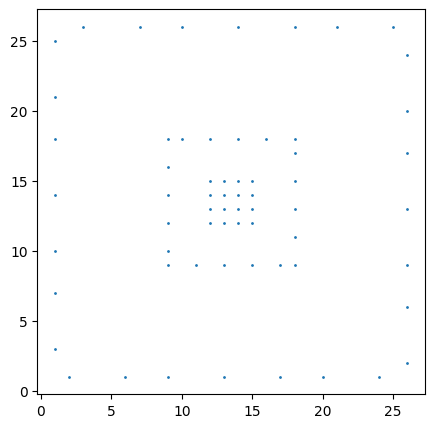

(64, 2)


In [21]:
all_indices = np.concatenate([fovea_indices, *sampled_indices])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(all_indices[:, 0], all_indices[:, 1], s=1)

plt.show()

print(all_indices.shape)

assert all_indices.shape[0] == foveated_im_dim**2

(12, 12)


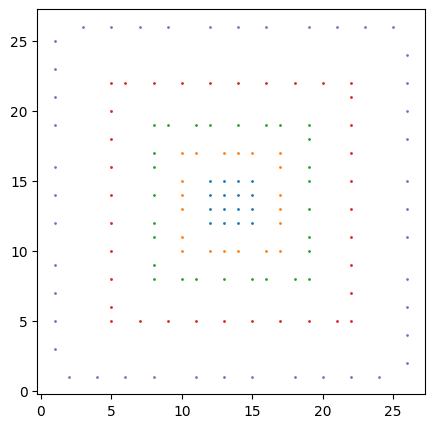

(144, 2)


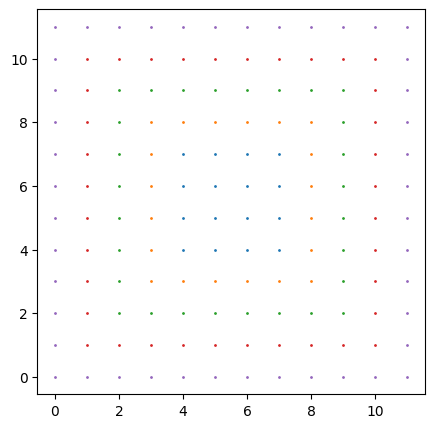

In [22]:
def get_sampled_ring_indices(
    x_extent, y_extent, x_center, y_center, fovea_radius, max_ring_radius, num_peri_rings_to_attempt
):
    """Get indices of pixels in a square foveated image of given radius centered at (x_center, y_center)"""

    # get peri indices
    a = np.exp((np.log(max_ring_radius / fovea_radius)) / num_peri_rings_to_attempt)
    peri_ring_radii = np.floor(
        [fovea_radius * a**i for i in range(1, num_peri_rings_to_attempt + 1)]
    )
    eligible_radius_mask = np.array(
        [fovea_radius < r <= max_ring_radius for r in peri_ring_radii]
    ).astype(bool)
    peri_ring_radii = peri_ring_radii[eligible_radius_mask].astype(int)
    num_peri_rings = len(peri_ring_radii)

    foveated_im_dim = 2 * (fovea_radius + num_peri_rings)

    if num_peri_rings != num_peri_rings_to_attempt:
        print(
            f"WARNING: {num_peri_rings_to_attempt} peri rings requested, but only {num_peri_rings} eligible. "
            f"Resulting size will be {foveated_im_dim}x{foveated_im_dim}"
        )

    # get fovea indices
    fovea_image_indices = np.concatenate(
        [
            get_indices_in_ring(x_extent, y_extent, x_center, y_center, r)
            for r in range(1, fovea_radius + 1)
        ]
    )
    fovea_mapped_indices = np.concatenate(
        [
            get_indices_in_ring(
                foveated_im_dim, foveated_im_dim, foveated_im_dim // 2, foveated_im_dim // 2, r
            )
            for r in range(1, fovea_radius + 1)
        ]
    )

    assert fovea_image_indices.shape == fovea_mapped_indices.shape

    # sampling ratios for each ring
    peri_sampling_ratios = [
        get_num_ring_pixels_from_r(fovea_radius + i + 1) / get_num_ring_pixels_from_r(r)
        for i, r in enumerate(peri_ring_radii)
    ]

    # sample evenly from each ring according to sampling ratio
    peri_image_indices = []
    peri_mapped_indices = []
    for i, r in enumerate(peri_ring_radii):
        foveated_r = fovea_radius + i + 1
        ri_image = get_indices_in_ring(x_extent, y_extent, x_center, y_center, r)
        ri_fov = get_indices_in_ring(
            foveated_im_dim, foveated_im_dim, foveated_im_dim // 2, foveated_im_dim // 2, foveated_r
        )

        # traverse ring indices clockwise starting from top left using arctan2
        ri_image = ri_image[
            np.argsort(np.arctan2(ri_image[:, 0] - x_center, ri_image[:, 1] - y_center))
        ]
        ri_fov = ri_fov[
            np.argsort(np.arctan2(ri_fov[:, 0] - foveated_im_dim // 2, ri_fov[:, 1] - foveated_im_dim // 2))
        ]

        # sample according to sampling ratio
        sample_n = np.floor(len(ri_image) * peri_sampling_ratios[i]).astype(int)
        sample = np.round(np.linspace(0, len(ri_image), sample_n, endpoint=False)).astype(int)
        ri_image = ri_image[sample]

        peri_image_indices.append(ri_image)
        peri_mapped_indices.append(ri_fov)

    # all_indices = np.concatenate([fovea_indices, *sampled_indices])

    return dict(
        foveated_image_size=(foveated_im_dim, foveated_im_dim),
        source_indices={
            "fovea": fovea_image_indices,
            "peripheral_rings": peri_image_indices,
        },
        mapped_indices={
            "fovea": fovea_mapped_indices,
            "peripheral_rings": peri_mapped_indices,
        },
    )


foveation_params = get_sampled_ring_indices(28, 28, 14, 14, 2, 14, 5)
print(foveation_params["foveated_image_size"])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    foveation_params["source_indices"]["fovea"][:, 0],
    foveation_params["source_indices"]["fovea"][:, 1],
    s=1,
    label=f"Fovea",
)
for i, ri in enumerate(foveation_params["source_indices"]["peripheral_rings"]):
    ax.scatter(ri[:, 0], ri[:, 1], s=1, label=f"ring {i}")

plt.show()

all_indices = np.concatenate(
    [
        foveation_params["source_indices"]["fovea"],
        *foveation_params["source_indices"]["peripheral_rings"],
    ]
)
print(all_indices.shape)
assert (
    np.sqrt(all_indices.shape[0])
    == foveation_params["foveated_image_size"][0]
    == foveation_params["foveated_image_size"][1]
)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    foveation_params["mapped_indices"]["fovea"][:, 0],
    foveation_params["mapped_indices"]["fovea"][:, 1],
    s=1,
    label=f"Fovea",
)
for i, ri in enumerate(foveation_params["mapped_indices"]["peripheral_rings"]):
    ax.scatter(ri[:, 0], ri[:, 1], s=1, label=f"ring {i}")

plt.show()


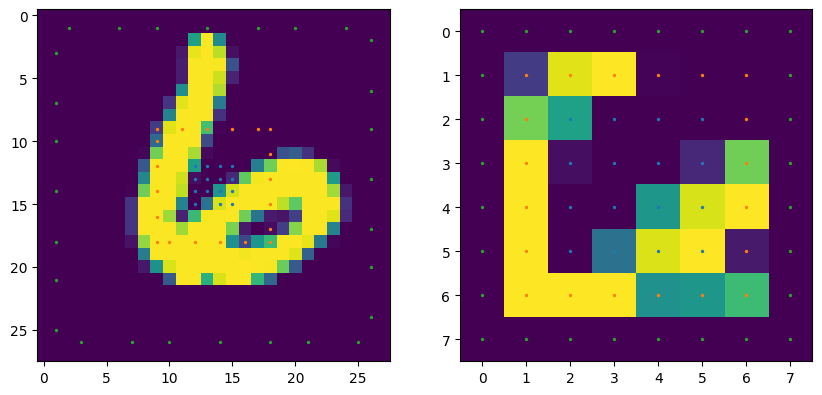

In [23]:
import torch.nn.functional as F


def sample_foveation_1to1(image, foveation_params):
    """Sample image according to foveation params"""
    c, h, w = image.shape
    foveated_image = np.zeros((c, *foveation_params["foveated_image_size"]))
    foveated_image[:, foveation_params["mapped_indices"]["fovea"][:, 0], foveation_params["mapped_indices"]["fovea"][:, 1]] = image[
        :, foveation_params["source_indices"]["fovea"][:, 0], foveation_params["source_indices"]["fovea"][:, 1]
    ]
    for i, ri in enumerate(foveation_params["source_indices"]["peripheral_rings"]):
        foveated_image[
            :, foveation_params["mapped_indices"]["peripheral_rings"][i][:, 0], foveation_params["mapped_indices"]["peripheral_rings"][i][:, 1]
        ] = image[:, ri[:, 0], ri[:, 1]]
    return foveated_image

image = images_with_pos[0]

foveation_params = get_sampled_ring_indices(
    x_extent=image.shape[1],
    y_extent=image.shape[2],
    x_center=14,
    y_center=14,
    fovea_radius=2,
    max_ring_radius=14,
    num_peri_rings_to_attempt=2,
)

# pad image to twice the size
# image = F.pad(image, (image.shape[1], image.shape[1], image.shape[2], image.shape[2]))

foveation = sample_foveation_1to1(image.numpy(), foveation_params)

def plot_image_and_points(image, fovea_points, peri_ring_points, ax, point_size=1):
    ax.imshow(image)
    ax.scatter(fovea_points[:, 0], fovea_points[:, 1], s=point_size, label=f"Fovea")
    for i, ri in enumerate(peri_ring_points):
        ax.scatter(ri[:, 0], ri[:, 1], s=point_size, label=f"ring {i}")

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plot_image_and_points(image[0], foveation_params["source_indices"]["fovea"], foveation_params["source_indices"]["peripheral_rings"], ax[0], point_size=2)
plot_image_and_points(foveation[0], foveation_params["mapped_indices"]["fovea"], foveation_params["mapped_indices"]["peripheral_rings"], ax[1], point_size=2)


# imshow_unnorm(image[[0]])
# imshow_unnorm(torch.tensor(foveation)[[0]])

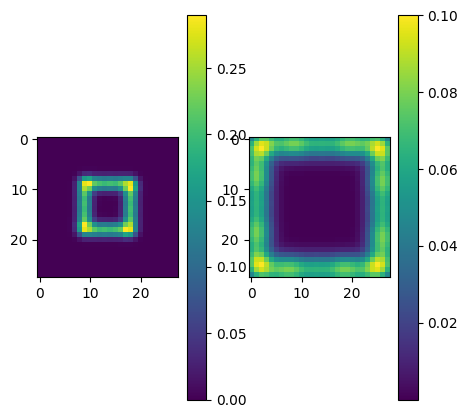

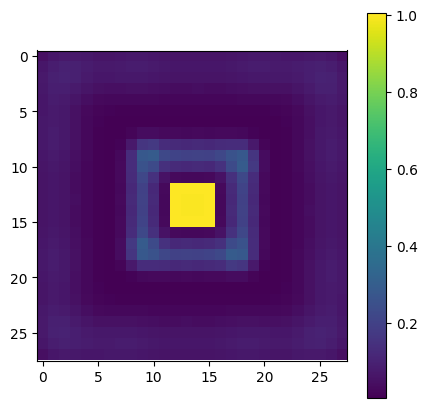

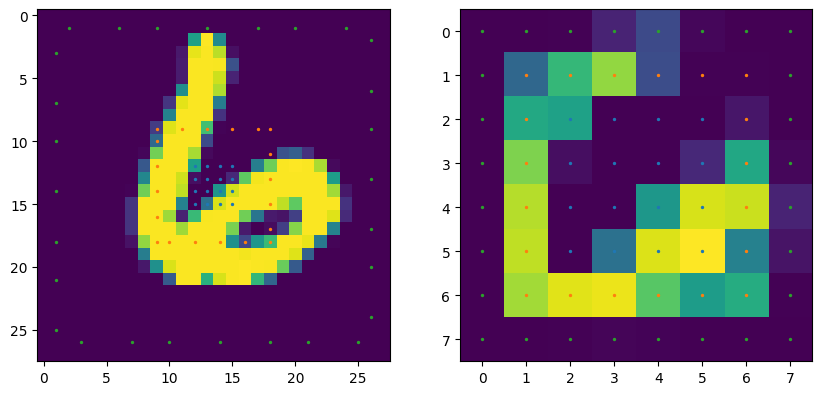

In [39]:
import torch.nn.functional as F


def sample_foveation_gaussian(image, foveation_params, ring_sigmas: Optional[List[float]]=None):
    """Sample image according to foveation params, sampling each peripheral point based on a Gaussian function
    of its distance to other points in the image
    Sampling is done via matrix-multiplication filtering
    """
    c, h, w = image.shape
    fov_h, fov_w = foveation_params["foveated_image_size"]

    assert len(ring_sigmas) == len(
        foveation_params["source_indices"]["peripheral_rings"]
    ), f"Must provide mu and sigma for each of {len(foveation_params['source_indices']['peripheral_rings'])} rings"

    # build filters
    foveation_filters = np.zeros((fov_h, fov_w, h, w))

    # fovea filters
    foveation_filters[
        foveation_params["mapped_indices"]["fovea"][:, 0],
        foveation_params["mapped_indices"]["fovea"][:, 1],
        foveation_params["source_indices"]["fovea"][:, 0],
        foveation_params["source_indices"]["fovea"][:, 1],
    ] = 1

    z_fig, z_ax = plt.subplots(
        1, len(foveation_params["source_indices"]["peripheral_rings"]), figsize=(5, 5)
    )
    for i, ri in enumerate(foveation_params["source_indices"]["peripheral_rings"]):
        # build gaussian
        x = np.arange(0, w)
        y = np.arange(0, h)
        xx, yy = np.meshgrid(x, y, indexing="ij")
        mu = ri
        sigma = ring_sigmas[i]

        # build gaussian
        # TODO: check formula
        z = np.exp(
            -((np.expand_dims(xx, -1) - mu[:, 0]) ** 2 + (np.expand_dims(yy, -1) - mu[:, 1]) ** 2)
            / (2 * sigma**2)
        )
        z = z / np.sum(z, axis=(0, 1))
        z_img = z_ax[i].imshow(z.sum(axis=2))
        z_fig.colorbar(z_img)

        foveation_filters[
            foveation_params["mapped_indices"]["peripheral_rings"][i][:, 0],
            foveation_params["mapped_indices"]["peripheral_rings"][i][:, 1],
        ] = z.transpose(2, 0, 1)

    filter_fig, filter_ax = plt.subplots(1, 1, figsize=(5, 5))
    g = filter_ax.imshow(foveation_filters.sum(axis=(0, 1)))
    filter_fig.colorbar(g)

    # apply filters
    _img = image.reshape((1 * c, h * w)).T
    _filters = foveation_filters.reshape((fov_h * fov_w, h * w))
    foveated_image = np.matmul(_filters, _img).reshape((fov_h, fov_w, c)).transpose(2, 0, 1)

    return foveated_image


image = images_with_pos[0]

foveation_params = get_sampled_ring_indices(
    x_extent=image.shape[1],
    y_extent=image.shape[2],
    x_center=14,
    y_center=14,
    fovea_radius=2,
    max_ring_radius=14,
    num_peri_rings_to_attempt=2,
)

# pad image to twice the size
# image = F.pad(image, (image.shape[1], image.shape[1], image.shape[2], image.shape[2]))

foveation = sample_foveation_gaussian(image.numpy(), foveation_params, ring_sigmas=[1, 2])


def plot_image_and_points(image, fovea_points, peri_ring_points, ax, point_size=1):
    ax.imshow(image)
    ax.scatter(fovea_points[:, 0], fovea_points[:, 1], s=point_size, label=f"Fovea")
    for i, ri in enumerate(peri_ring_points):
        ax.scatter(ri[:, 0], ri[:, 1], s=point_size, label=f"ring {i}")


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
plot_image_and_points(
    image[0],
    foveation_params["source_indices"]["fovea"],
    foveation_params["source_indices"]["peripheral_rings"],
    ax[0],
    point_size=2,
)
plot_image_and_points(
    foveation[0],
    foveation_params["mapped_indices"]["fovea"],
    foveation_params["mapped_indices"]["peripheral_rings"],
    ax[1],
    point_size=2,
)

# imshow_unnorm(image[[0]])
# imshow_unnorm(torch.tensor(foveation)[[0]])
